In [1]:
import os
import pandas as pd
import sqlalchemy as sql
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import scipy.optimize as sco

# https://pypi.org/project/yfinance/
import yfinance as yf

import hvplot.pandas
import holoviews as hv
import seaborn as sns
import copy
import warnings

from pathlib import Path
# https://pandas-datareader.readthedocs.io/en/latest/
from pandas_datareader import data as pdr
from pandas import Timestamp as tstamp
from pandas import read_csv as rcsv
from pandas import read_sql_query as rsqq
from sqlalchemy import (
    create_engine as ce,
    inspect
)

# Import date and timedelta class
from datetime import date
from datetime import timedelta
from scipy import stats

from MCForecastTools import MCSimulation
from calculations import MPTCalculations as mpt
from metrics import QuantMetrics as qm
from dataset import DataCollection as ds

warnings.filterwarnings('ignore')

print(f"Package imports and dependencies resolved")

Package imports and dependencies resolved


### Modern Portfolio Theory Based Portfolio Analysis and Optimization

---
Steps Involved:
1. Project Settings
2. Data Preparation (Data Collection, Clean and Format)
3. Quantitative Analysis
4. Visualizations

### 1. Project Settings
- Define the time delta (time-frame) to start with in the historical time reference.

In [2]:
# Specifiy date range for data
# Set start and end dates of 5 years "5Y" back from your current date
# Define the time delta (time-frame) to start with
time_delta = 5

end_date = pd.to_datetime('today')
# 5 years
start_date = end_date - np.timedelta64(time_delta, 'Y')
start, end = start_date, end_date
# Verify date range
print(f"Start date: {start} and End date: {end}")

Start date: 2017-10-20 06:41:39.111501 and End date: 2022-10-20 11:47:39.111501


### Add or remove stocks of possible sectors
- tech_list or others to evaluate the asset performance
- refer to dataset.py for the entire sector list

In [3]:
# Specify portfolio sectors - basket of market index and assets - S&P 500 Index (^GSPC) and Tech Stocks List
basket_list = ds.market + ds.tech_list

print("Basket of stocks")
print(basket_list)

Basket of stocks
['^GSPC', 'AAPL', 'IBM', 'TSLA', 'GOOGL', 'MSFT', 'CSCO', 'TSM', 'NVDA']


### 2. Data Preparation

In [4]:
# Dataframe closing prices of basket, i.e. market index and assets
# Fetch data from Yahoo Finance API
stock_data, raw_data = ds.get_raw_data(basket_list, start, end)
stock_data.rename(columns = {'^GSPC':'SP500_index'}, inplace = True)
stock_data = stock_data.reset_index()
raw_data.rename(columns = {'^GSPC':'SP500_index'}, inplace = True)

In [5]:
# Output raw data is raw_frame_close
display(raw_data.shape)
# Review random 5 rows from dataframe
display(raw_data.sample(5))

(1259, 54)

Attributes    Adj Close                                                  \
Symbols     SP500_index        AAPL         IBM        TSLA       GOOGL   
Date                                                                      
2021-02-08  3915.590088  135.712891  108.474777  287.806671  104.225998   
2018-10-25  2705.570068   52.939671   99.346581   20.990667   55.179501   
2019-05-08  2879.419922   49.250072  111.081131   16.322666   58.539001   
2018-02-08  2581.000000   36.944214  113.456566   21.015333   50.385502   
2020-01-09  3274.699951   75.960190  114.017586   32.089333   70.989502   

Attributes                                                       Close  ...  \
Symbols           MSFT       CSCO         TSM        NVDA  SP500_index  ...   
Date                                                                    ...   
2021-02-08  238.893616  46.472691  128.437057  144.163589  3915.590088  ...   
2018-10-25  103.598106  40.269535   33.700005   51.540901  2705.570068  ...   
2019-05-08  121.094536  48.023365   39.387276   43.216949  2879.419922  ...   
2018-02-08   80.280785  33.571590   35.093407   53.845116  2581.000000  ...   
2020-01-09  158.025146  43.408749   55.905148   60.560863  3274.699951  ...   

Attributes        Open        Volume                                        \
Symbols           NVDA   SP500_index         AAPL         IBM         TSLA   
Date                                                                         
2021-02-08  137.272507  4.635030e+09   71297200.0   6158848.0   60485100.0   
2018-10-25   48.867500  4.634770e+09  119423200.0  10778298.0  312610500.0   
2019-05-08   43.000000  3.485790e+09  105358000.0   3994569.0   92646000.0   
2018-02-08   58.470001  5.305440e+09  217562000.0   7090939.0  154719000.0   
2020-01-09   60.962502  3.638390e+09  170108400.0   3902208.0  426606000.0   

Attributes                                                               
Symbols          GOOGL        MSFT        CSCO         TSM         NVDA  
Date                                                                     
2021-02-08  28828000.0  22211900.0  25215400.0  11160000.0   43462400.0  
2018-10-25  72956000.0  61646800.0  27054500.0   9927300.0   95172000.0  
2019-05-08  25520000.0  28419000.0  21525100.0   8112600.0   41916800.0  
2018-02-08  66792000.0  55628700.0  42982100.0  11356000.0  114400000.0  
2020-01-09  33200000.0  21385000.0  18203600.0   5112700.0   25511200.0  

[5 rows x 54 columns]

In [6]:
# Output cleaned data to 'Close' prices is stock_data, cut table down to 29 columns from 174 columns
display(stock_data.shape)
print("Review random 5 rows from dataframe")
# Review random 5 rows from dataframe
display(stock_data.sample(5))

(1259, 10)

Review random 5 rows from dataframe


Symbols       Date  SP500_index        AAPL         IBM        TSLA  \
634     2020-04-30  2912.429932   73.449997  120.038239   52.125332   
715     2020-08-25  3443.620117  124.824997  119.158699  134.889328   
1076    2022-01-31  4515.549805  174.779999  133.570007  312.239990   
567     2020-01-24  3295.469971   79.577499  134.378586   37.654667   
1148    2022-05-13  4023.889893  147.110001  133.600006  256.529999   

Symbols       GOOGL        MSFT       CSCO         TSM        NVDA  
634       67.334999  179.210007  42.380001   53.130001   73.070000  
715       80.292503  216.470001  41.959999   80.040001  127.500000  
1076     135.303497  310.980011  55.669998  122.629997  244.860001  
567       73.308502  165.039993  48.849998   57.730000   62.619999  
1148     116.050499  261.119995  49.560001   90.959999  177.059998

In [7]:
# Import the [offline stored] data from the csv file
# Generate dataframe setting the DatetimeIndex with 'date' as as index. 
working_raw_data = rcsv(
    Path('data/raw_frame_close.csv'),
    index_col=0,
    parse_dates=True,
    infer_datetime_format=True,
    header = [0,1]
)

# Output dataframe name is working_raw_frame_close
print('Sample row of DataFrame from local csv data source path:')
display(working_raw_data.shape)

# Display sample 5 rows of dataframe
display(working_raw_data.sample(5))

Sample row of DataFrame from local csv data source path:


(1259, 54)

Attributes    Adj Close                                                 \
Symbols           ^GSPC        AAPL         IBM        TSLA      GOOGL   
Date                                                                     
2020-01-21  3320.790039   77.662750  116.043793   36.480000  74.112503   
2020-09-30  3363.000000  114.428680  105.246201  143.003326  73.279999   
2020-04-13  2761.629883   67.194336  102.073051   43.396667  60.520500   
2018-09-05  2888.600098   54.642506  115.224731   18.716000  59.955002   
2018-05-17  2720.129883   44.879856  112.314301   18.969334  54.063000   

Attributes                                                      Close  ...  \
Symbols           MSFT       CSCO        TSM        NVDA        ^GSPC  ...   
Date                                                                   ...   
2020-01-21  162.324539  44.766422  54.970726   61.786926  3320.790039  ...   
2020-09-30  206.686539  36.764145  78.224411  135.055298  3363.000000  ...   
2020-04-13  161.800095  38.171467  46.449986   67.287132  2761.629883  ...   
2018-09-05  103.779869  41.582527  39.855961   69.043587  2888.600098  ...   
2018-05-17   91.651588  37.935272  33.876091   61.356476  2720.129883  ...   

Attributes        Open        Volume                                       \
Symbols           NVDA         ^GSPC         AAPL        IBM         TSLA   
Date                                                                        
2020-01-21   61.952499  4.105340e+09  110843200.0  7577329.0  267052500.0   
2020-09-30  131.574997  4.722530e+09  142675200.0  3411111.0  144436800.0   
2020-04-13   65.137497  5.274310e+09  131022800.0  5355206.0  337131000.0   
2018-09-05   70.747498  3.241250e+09  133332000.0  3270319.0  115812000.0   
2018-05-17   61.520000  3.475400e+09   69176000.0  3292494.0   66309000.0   

Attributes                                                             
Symbols          GOOGL        MSFT        CSCO        TSM        NVDA  
Date                                                                   
2020-01-21  48930000.0  29517200.0  21771800.0  9873700.0  21791600.0  
2020-09-30  40924000.0  33829100.0  27113200.0  5878900.0  68918400.0  
2020-04-13  38702000.0  41905300.0  19592000.0  9873200.0  39840800.0  
2018-09-05  53988000.0  32872400.0  20818100.0  7262400.0  39315600.0  
2018-05-17  25738000.0  17246700.0  48210400.0  7964200.0  51978400.0  

[5 rows x 54 columns]

In [8]:
# Verify Close columns of each stocks and index
working_raw_data['Close']

Symbols           ^GSPC        AAPL         IBM        TSLA       GOOGL  \
Date                                                                      
2017-10-20  2575.209961   39.062500  154.942642   23.006666   50.253502   
2017-10-23  2564.979980   39.042500  152.533463   22.468000   49.277000   
2017-10-24  2569.129883   39.275002  149.024857   22.489332   49.424500   
2017-10-25  2557.149902   39.102501  146.749527   21.722668   49.573002   
2017-10-26  2560.399902   39.352501  146.845123   21.744667   49.570999   
...                 ...         ...         ...         ...         ...   
2022-10-14  3583.070068  138.380005  120.040001  204.990005   96.559998   
2022-10-17  3677.949951  142.410004  121.519997  219.350006   99.970001   
2022-10-18  3719.979980  143.750000  122.940002  220.190002  100.769997   
2022-10-19  3695.159912  143.860001  122.510002  222.039993   99.629997   
2022-10-20  3719.360107  145.479996  127.830002  213.339600  101.739998   

Symbols           MSFT       CSCO        TSM        NVDA  
Date                                                      
2017-10-20   78.809998  34.250000  41.119999   49.224998  
2017-10-23   78.830002  34.349998  41.209999   49.154999  
2017-10-24   78.860001  34.580002  41.320000   49.669998  
2017-10-25   78.629997  34.299999  41.160000   48.415001  
2017-10-26   78.760002  34.270000  41.200001   48.922501  
...                ...        ...        ...         ...  
2022-10-14  228.559998  40.200001  63.919998  112.269997  
2022-10-17  237.529999  41.299999  64.889999  118.879997  
2022-10-18  238.500000  41.790001  63.709999  119.669998  
2022-10-19  236.479996  41.880001  63.660000  120.510002  
2022-10-20  239.789993  42.355000  65.050003  126.360001  

[1259 rows x 9 columns]

### Create 'basket' from SQLite temp db

In [9]:
# Fetch date indexed and unindexed data frames created out of SQLite temp db
sql_basket_indexed_df, sql_basket_df = ds.sqlite_data(stock_data)

print("Unindexed dataframe counts and column summary")
display(sql_basket_df.shape) 
# Display sample 5 rows of unindexed dataframe
display(sql_basket_df.sample(5))

print("Indexed dataframe counts and column summary")
display(sql_basket_indexed_df.shape) 

# Display sample 5 rows of indexed datafarme
display(sql_basket_indexed_df.sample(5))

Unindexed dataframe counts and column summary


(1259, 10)

Date  SP500_index        AAPL         IBM        TSLA       GOOGL  \
429  2019-07-09  2979.629883   50.310001  133.202682   15.337333   56.214500   
639  2020-05-07  2881.189941   75.934998  115.898659   52.002666   68.463997   
598  2020-03-10  2882.229980   71.334999  119.282982   43.021999   63.758499   
769  2020-11-10  3545.530029  115.970001  112.724663  136.786667   86.886002   
1013 2021-10-29  4605.379883  149.800003  119.598473  371.333344  148.046005   

            MSFT       CSCO         TSM        NVDA  
429   136.460007  56.340000   39.669998   39.327499  
639   183.600006  41.369999   52.330002   76.217499  
598   160.919998  40.080002   54.509998   65.269997  
769   211.009995  38.720001   87.660004  127.699997  
1013  331.619995  55.970001  113.699997  255.669998

Indexed dataframe counts and column summary


(1259, 9)

SP500_index        AAPL         IBM        TSLA       GOOGL  \
Date                                                                      
2021-09-10  4458.580078  148.970001  130.994263  245.423340  140.876007   
2019-10-09  2919.399902   56.757500  133.527725   16.302000   60.119999   
2020-09-09  3398.959961  117.320000  116.883362  122.093330   77.361504   
2021-02-08  3915.590088  136.910004  118.173996  287.806671  104.225998   
2018-02-09  2619.550049   39.102501  142.934998   20.694668   52.313499   

                  MSFT       CSCO         TSM        NVDA  
Date                                                       
2021-09-10  295.709991  57.889999  122.970001  224.779999  
2019-10-09  138.240005  46.840000   48.680000   45.177502  
2020-09-09  211.289993  40.130001   79.400002  127.150002  
2021-02-08  242.470001  48.939999  132.550003  144.387497  
2018-02-09   88.180000  39.529999   41.470001   58.020000

### 3. Quant Analysis

In [10]:
# Display constants being used in quant analysis
print("Number of trading days per year = ", qm.num_trading_days)
print("Risk free rate = ", qm.risk_free_rate)
print("Number of random portfolio runs = ", qm.num_random_portfolio_run)
print("Number of days in rolling window = ", qm.rolling_window_days)
print("Number of days of input dataframe to use as historical data = ", mpt.historical_days_percent)
print("Number of days of input dataframe to use as test/experiment data  = ", mpt.test_days_percent)

Number of trading days per year =  252
Risk free rate =  0.0275
Number of random portfolio runs =  10000
Number of days in rolling window =  20
Number of days of input dataframe to use as historical data =  0.8
Number of days of input dataframe to use as test/experiment data  =  0.19999999999999996


In [11]:
display(sql_basket_indexed_df.shape)

(1259, 9)

In [12]:
# Break up the input asset price data frame into 2 chunks
# (1) For use of historical data to determine what the optimum portfolio selection should be
# (2) For test purposes,test how wll the portfolio allocation performs
num_days_total = sql_basket_indexed_df.shape[0]
num_historical_days_percent = round(num_days_total * mpt.historical_days_percent)
num_test_days_percent = round(num_days_total * mpt.test_days_percent)

print("Total # of days in asset dataframe = ", num_days_total)
print("Total # of days will use for hisotrical data = ", num_historical_days_percent)
print("Total # of days will use for testing results = ", num_test_days_percent)


# Extract the days from full dataframe will use for historical data
asset_mkt_prices_historical_df = sql_basket_indexed_df.iloc[0:num_historical_days_percent-1, :].copy()
asset_mkt_prices_test_df = sql_basket_indexed_df.iloc[num_historical_days_percent:num_days_total-1,:].copy()

Total # of days in asset dataframe =  1259
Total # of days will use for hisotrical data =  1007
Total # of days will use for testing results =  252


In [13]:
# Plot the individual asset prices taking previous 4 years (80% of 5 years period)
asset_mkt_prices_historical_df.drop('SP500_index', axis=1, inplace=False).hvplot.line(
    ylabel="Prices", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="(In-Test) Performance of Historical Assets Prices"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [14]:
# Plot the individual asset prices in the next 1 year (20% of 5 years period)
asset_mkt_prices_test_df.drop('SP500_index', axis=1, inplace=False).hvplot.line(
    ylabel="Prices", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="(Out-of-Test) Assets Prices"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

#### Calculate Descriptive Stats
---
* Asset Returns, Standard Deviation, Cumulative Returns, Covariance, Correlation Matrix, Sharpe Ratio

In [15]:
# Compute the frequency components on asset prices
asset_mkt_prices_returns_df,        \
asset_mkt_prices_ann_returns_mean,  \
asset_mkt_prices_std_df,            \
asset_mkt_prices_ann_std_df,        \
asset_mkt_prices_std_rolling_df,    \
asset_mkt_prices_ann_cov_mtrx_df,   \
asset_mkt_prices_ann_corr_mtrx_df,  \
asset_mkt_prices_cum_returns_df,    \
asset_prices_sharpe_ratio_df,       \
log_returns                           = qm.mpt_qa_compute_freq_stats(asset_mkt_prices_historical_df)

In [16]:
# Review daily returns DataFrame
print("Asset Returns:")
display(asset_mkt_prices_returns_df.shape)
# Display randow 5 rows of the returns
display(asset_mkt_prices_returns_df.sample(5))

Asset Returns:


(1005, 9)

SP500_index      AAPL       IBM      TSLA     GOOGL      MSFT  \
Date                                                                        
2020-07-17     0.002849 -0.002020  0.008870  0.000133  0.001274 -0.005100   
2018-08-28     0.000269  0.008076 -0.000682 -0.023209 -0.008286  0.006022   
2019-01-23     0.002203  0.004044  0.084639 -0.037903  0.005359  0.009746   
2019-12-30    -0.005781  0.005935 -0.018186 -0.036433 -0.011021 -0.008619   
2018-10-30     0.015667  0.004994 -0.035440 -0.014783  0.014284 -0.001155   

                CSCO       TSM      NVDA  
Date                                      
2020-07-17  0.021188 -0.002853  0.006586  
2018-08-28  0.007727  0.019745 -0.005509  
2019-01-23  0.015185  0.003299  0.003495  
2019-12-30 -0.003768 -0.010434 -0.019209  
2018-10-30  0.016880  0.039912  0.093632

In [17]:
# Plot the distribution of the returns of the individual assets
asset_mkt_prices_returns_df.hvplot.hist(bins=100, subplots=True, width=400, group_label='Ticker', grid=True).cols(3)

:NdLayout   [Default]
   :Histogram   [NVDA]   (NVDA_count)

In [18]:
# Plot the asset cumulative returns
asset_mkt_prices_cum_returns_df.hvplot.line(
    ylabel="Cum Returns", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="Market & Assets Cumulative Returns"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

<AxesSubplot:title={'center':'Asset & Market: Daily Returns Box Plot'}>

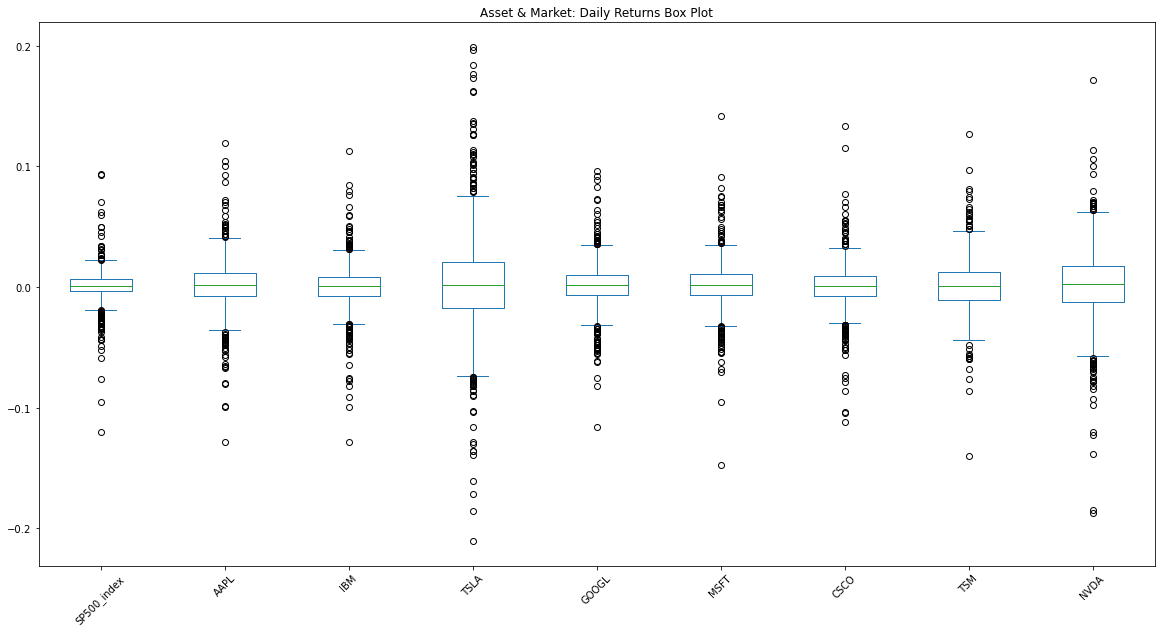

In [19]:
# Use the daily return data to create box plots to visualize the volatility of the assets 
asset_mkt_prices_returns_df.plot.box(figsize=(20, 10), rot=45, title = "Asset & Market: Daily Returns Box Plot")

In [20]:
# Sort the asset deviations
asset_mkt_prices_ann_std_sorted_df = asset_mkt_prices_ann_std_df.sort_values()

print("Asset annualized standard deviations (Sorted):")
display(asset_mkt_prices_ann_std_sorted_df)

Asset annualized standard deviations (Sorted):


SP500_index    0.210748
IBM            0.280475
CSCO           0.290045
GOOGL          0.290225
MSFT           0.297856
AAPL           0.326961
TSM            0.334088
NVDA           0.472404
TSLA           0.638993
dtype: float64

In [21]:
# Dispaly the (sorted) asset sharpe ratios
print("Assets & Market: Annual Sharpe Ratio (Sorted):")
display(asset_prices_sharpe_ratio_df.sort_values())

asset_prices_sharpe_ratio_df.hvplot(
    kind = 'bar',
    width = 800,
    height = 500,
    hover_color = 'magenta',
    rot = 45,
    title = "Assets & Market: Annual Sharpe Ratio")

Assets & Market: Annual Sharpe Ratio (Sorted):


IBM            0.022842
CSCO           0.566450
SP500_index    0.775480
TSM            0.951815
NVDA           1.041153
GOOGL          1.050646
AAPL           1.189757
MSFT           1.297798
TSLA           1.310575
dtype: float64

:Bars   [index]   (0)

In [22]:
# Drop the market from asset/mkt data frame
asset_prices_df = asset_mkt_prices_historical_df.drop(['SP500_index'], axis=1, inplace=False)
print("Asset Prices DataFrame (does not include market)")
display(asset_prices_df)

market_df = pd.DataFrame(asset_mkt_prices_returns_df['SP500_index'])

# Recompute frequence components (e.g. covariance matrix will be different).
asset_mkt_prices_returns_df,        \
asset_mkt_prices_ann_returns_mean,  \
asset_mkt_prices_std_df,            \
asset_mkt_prices_ann_std_df,        \
asset_mkt_prices_std_rolling_df,    \
asset_mkt_prices_ann_cov_mtrx_df,   \
asset_mkt_prices_ann_corr_mtrx_df,  \
asset_mkt_prices_cum_returns_df,    \
asset_prices_sharpe_ratio_df,       \
log_returns                           = qm.mpt_qa_compute_freq_stats(asset_prices_df)

Asset Prices DataFrame (does not include market)


AAPL         IBM        TSLA       GOOGL        MSFT  \
Date                                                                     
2017-10-20   39.062500  154.942642   23.006666   50.253502   78.809998   
2017-10-23   39.042500  152.533463   22.468000   49.277000   78.830002   
2017-10-24   39.275002  149.024857   22.489332   49.424500   78.860001   
2017-10-25   39.102501  146.749527   21.722668   49.573002   78.629997   
2017-10-26   39.352501  146.845123   21.744667   49.570999   78.760002   
...                ...         ...         ...         ...         ...   
2021-10-13  140.910004  134.569794  270.359985  137.582001  296.309998   
2021-10-14  143.759995  137.084137  272.773346  141.151001  302.750000   
2021-10-15  144.839996  138.250473  281.010010  141.367996  304.209991   
2021-10-18  146.550003  136.061188  290.036682  142.778000  307.290009   
2021-10-19  148.759995  135.736145  288.089996  143.237000  308.230011   

                 CSCO         TSM        NVDA  
Date                                           
2017-10-20  34.250000   41.119999   49.224998  
2017-10-23  34.349998   41.209999   49.154999  
2017-10-24  34.580002   41.320000   49.669998  
2017-10-25  34.299999   41.160000   48.415001  
2017-10-26  34.270000   41.200001   48.922501  
...               ...         ...         ...  
2021-10-13  54.619999  109.980003  209.389999  
2021-10-14  55.650002  112.559998  217.460007  
2021-10-15  55.250000  114.860001  218.619995  
2021-10-18  55.189999  115.339996  222.220001  
2021-10-19  55.740002  116.959999  222.899994  

[1006 rows x 8 columns]

In [23]:
print("Annual Covariance Matrix:")
display(asset_mkt_prices_ann_cov_mtrx_df.head())

print("Correlation Matrix:")
display(asset_mkt_prices_ann_corr_mtrx_df)

Annual Covariance Matrix:


AAPL       IBM      TSLA     GOOGL      MSFT      CSCO       TSM  \
AAPL   0.106904  0.043435  0.087485  0.064079  0.073720  0.057501  0.061500   
IBM    0.043435  0.078666  0.041579  0.041477  0.045272  0.051355  0.041203   
TSLA   0.087485  0.041579  0.408313  0.069027  0.081840  0.051151  0.077399   
GOOGL  0.064079  0.041477  0.069027  0.084230  0.068309  0.049794  0.051474   
MSFT   0.073720  0.045272  0.081840  0.068309  0.088718  0.058291  0.057116   

           NVDA  
AAPL   0.098938  
IBM    0.055873  
TSLA   0.125759  
GOOGL  0.087428  
MSFT   0.098564

Correlation Matrix:


AAPL       IBM      TSLA     GOOGL      MSFT      CSCO       TSM  \
AAPL   1.000000  0.473643  0.418734  0.675280  0.756973  0.606339  0.563014   
IBM    0.473643  1.000000  0.231999  0.509536  0.541914  0.631287  0.439723   
TSLA   0.418734  0.231999  1.000000  0.372212  0.429994  0.275988  0.362557   
GOOGL  0.675280  0.509536  0.372212  1.000000  0.790204  0.591526  0.530872   
MSFT   0.756973  0.541914  0.429994  0.790204  1.000000  0.674726  0.573971   
CSCO   0.606339  0.631287  0.275988  0.591526  0.674726  1.000000  0.483532   
TSM    0.563014  0.439723  0.362557  0.530872  0.573971  0.483532  1.000000   
NVDA   0.640550  0.421691  0.416610  0.637676  0.700484  0.547342  0.622749   

           NVDA  
AAPL   0.640550  
IBM    0.421691  
TSLA   0.416610  
GOOGL  0.637676  
MSFT   0.700484  
CSCO   0.547342  
TSM    0.622749  
NVDA   1.000000

[Text(0.5, 1.0, 'Asset Prices Correlation Matrix')]

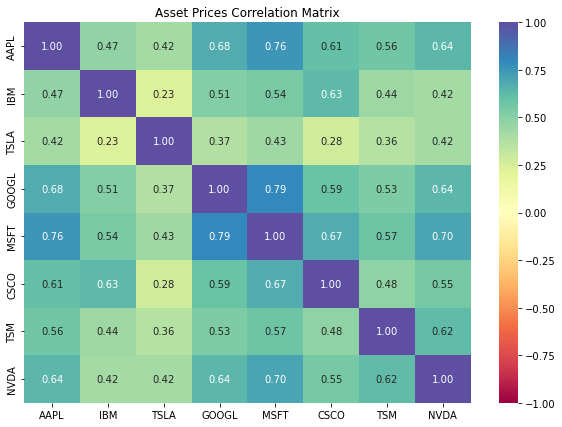

In [24]:
# Use the `heatmap` function from the seaborn library to visualize the correlation matrix
plt.figure(figsize = (10,7))
sns.heatmap(
    asset_mkt_prices_ann_corr_mtrx_df, 
    annot=True, 
    vmin=-1, 
    vmax=1, 
    fmt=".2f", 
    cmap="Spectral"
).set(
    title='Asset Prices Correlation Matrix')

In [25]:
print("Annual average asset returns:")
display(asset_mkt_prices_ann_returns_mean)

Annual average asset returns:


AAPL     0.389005
IBM      0.006407
TSLA     0.837449
GOOGL    0.304923
MSFT     0.386557
CSCO     0.164296
TSM      0.317990
NVDA     0.491845
dtype: float64

### Efficient Frontier Computation

In [26]:
# Determine the efficient frontier components
efficient_frontier_df = qm.mpt_qa_get_efficient_frontier(asset_prices_df, asset_mkt_prices_ann_returns_mean, asset_mkt_prices_ann_cov_mtrx_df)

print("Efficient Frontier DataFrame:")
display(efficient_frontier_df.shape)

print("Print random 5 rows of Efficient Frontier sample points")
display(efficient_frontier_df.sample(5))

Efficient Frontier DataFrame:


(10000, 11)

Print random 5 rows of Efficient Frontier sample points


Returns  Volatility  SharpeRatio    AAPL_W     IBM_W    TSLA_W  \
2285  0.401013    4.630491     0.080664  0.168371  0.092133  0.184509   
8346  0.328830    4.309194     0.069927  0.097344  0.225193  0.073194   
5280  0.310420    4.118705     0.068691  0.098257  0.219761  0.125205   
3959  0.227293    4.189187     0.047693  0.016188  0.335726  0.052843   
8807  0.318267    4.412707     0.065893  0.155264  0.199772  0.030628   

       GOOGL_W    MSFT_W    CSCO_W     TSM_W    NVDA_W  
2285  0.140702  0.005834  0.092371  0.203550  0.112531  
8346  0.044408  0.220549  0.019101  0.179486  0.140726  
5280  0.072282  0.233297  0.186117  0.051046  0.014036  
3959  0.037372  0.030532  0.302399  0.051332  0.173608  
8807  0.111354  0.098677  0.051628  0.132891  0.219785

In [27]:
# Select the following portfolio allocations:
# (1) Based on the "minimum" risk
# (2) Based on the "maximum" risk
# (3) Based on the "optimum sharpe ratio"
portfolio_min_volatility, portfolio_max_volatility, portfolio_opt_sharpe_ratio = qm.mpt_qa_return_portfolio_allocations(efficient_frontier_df)

print("Efficient Frontier: Min Volatility Point:")
display(portfolio_min_volatility)
print("\nEfficient Frontier: Max Volatility Point:")
display(portfolio_max_volatility)
print("\nEfficient Frontier: Opt Sharpe Ratio Volatility Point:")
display(portfolio_opt_sharpe_ratio)

Efficient Frontier: Min Volatility Point:


Returns        0.210846
Volatility     3.816874
SharpeRatio    0.048036
AAPL_W         0.041486
IBM_W          0.292182
TSLA_W         0.007324
GOOGL_W        0.122475
MSFT_W         0.148241
CSCO_W         0.206159
TSM_W          0.180606
NVDA_W         0.001527
Name: 546, dtype: float64


Efficient Frontier: Max Volatility Point:


Returns        0.540666
Volatility     6.173472
SharpeRatio    0.083124
AAPL_W         0.000707
IBM_W          0.116915
TSLA_W         0.470408
GOOGL_W        0.031877
MSFT_W         0.087806
CSCO_W         0.105443
TSM_W          0.041327
NVDA_W         0.145517
Name: 5686, dtype: float64


Efficient Frontier: Opt Sharpe Ratio Volatility Point:


Returns        0.514248
Volatility     5.380897
SharpeRatio    0.090459
AAPL_W         0.158402
IBM_W          0.012081
TSLA_W         0.310176
GOOGL_W        0.152499
MSFT_W         0.225309
CSCO_W         0.028440
TSM_W          0.006309
NVDA_W         0.106783
Name: 5091, dtype: float64

In [28]:
# Plot the efficient frontier #3 (Efficient frontier + porfolio selection points + 3rd color dimension of the sharpe ratio points)
scatter = hv.Scatter((efficient_frontier_df['Volatility'], efficient_frontier_df['Returns'], efficient_frontier_df.loc[:,'SharpeRatio']), 'Volatility', ['Return', 'Sharpe Ratio'])
max_sharpe = hv.Scatter([(portfolio_opt_sharpe_ratio[1],portfolio_opt_sharpe_ratio[0])])
min_volatility = hv.Scatter([(portfolio_min_volatility[1],portfolio_min_volatility[0])])
max_volatility = hv.Scatter([(portfolio_max_volatility[1],portfolio_max_volatility[0])])

scatter.opts(title="Efficient Frontier + Min/Max/OptSharpeRatio Selections", color='Sharpe Ratio', cmap='plasma', width=800, height=600, colorbar=True, padding=0.1) *\
max_sharpe.opts(color='blue', line_color='black', size=15,) *\
min_volatility.opts(color='yellow', line_color='black', size=15) *\
max_volatility.opts(color='red', line_color='black', size=15)


:Overlay
   .Scatter.I   :Scatter   [Volatility]   (Return,Sharpe Ratio)
   .Scatter.II  :Scatter   [x]   (y)
   .Scatter.III :Scatter   [x]   (y)
   .Scatter.IV  :Scatter   [x]   (y)

### Visualization for: "mpt_performance_eval.py"

In [29]:
# Select the following portfolio allocations:
# (1) Based on the "minimum volatility" risk
# (2) Based on the "maximum returns" risk
# (3) Based on the "optimum sharpe ratio"
portfolio_min_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_min_volatility)
portfolio_max_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_max_volatility)
portfolio_opt_sharpe_ratio_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_opt_sharpe_ratio)

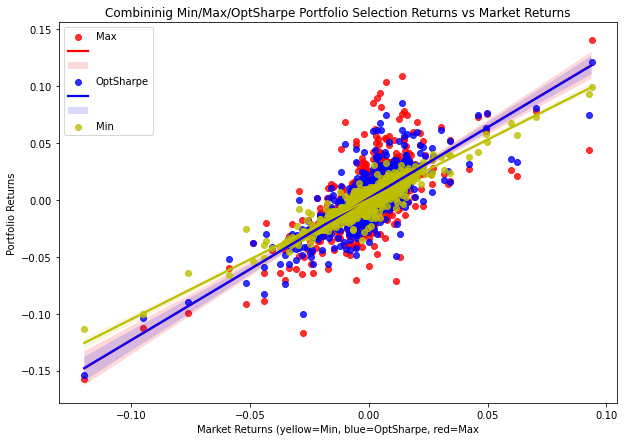

In [30]:
plt.subplots(figsize=(10,7))

x_df = market_df.reset_index(drop=True)
y_df = portfolio_max_volatility_returns_df
z_df = pd.concat([x_df, y_df], axis=1, join="inner")
z_df.columns = ["Market", "MaxVol"]
sns.regplot(x="Market", y="MaxVol", data=z_df, color='r')

y_df = portfolio_opt_sharpe_ratio_volatility_returns_df
z_df = pd.concat([x_df, y_df], axis=1, join="inner")
z_df.columns = ["Market", "OptSharpe"]
sns.regplot(x="Market", y="OptSharpe", data=z_df, color='b')

y_df = portfolio_min_volatility_returns_df
z_df = pd.concat([x_df, y_df], axis=1, join="inner")
z_df.columns = ["Market", "MinReturns"]
sns.regplot(x="Market", y="MinReturns", data=z_df, color='y')

plt.xlabel("Market Returns (yellow=Min, blue=OptSharpe, red=Max")
plt.ylabel("Portfolio Returns")
plt.legend(["Max", "", "", "OptSharpe", "", "", "Min"])
plt.title("Combininig Min/Max/OptSharpe Portfolio Selection Returns vs Market Returns")

plt.show()

<AxesSubplot:title={'center':'Portfolio Composition - Min Protfolio'}, ylabel='weights'>

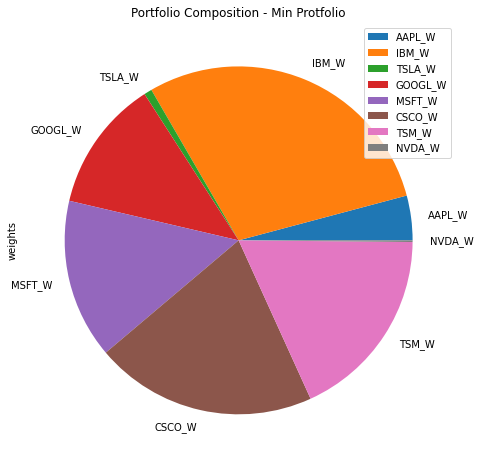

In [31]:
portfolio_min_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_min_volatility)

# Plot the pie charts of the porfolio allocation/weights
portfolio_min_weights.plot.pie(
    y='weights', 
    title='Portfolio Composition - Min Protfolio',
    figsize=(10,8))

<AxesSubplot:title={'center':'Portfolio Composition - Max Protfolio'}, ylabel='weights'>

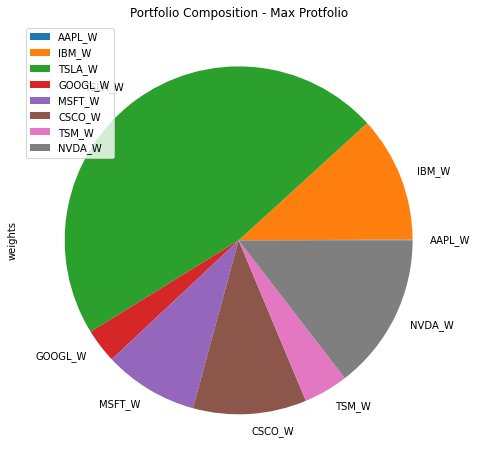

In [32]:
portfolio_max_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_max_volatility)

# Plot the pie charts of the porfolio allocation/weights
portfolio_max_weights.plot.pie(y='weights', title='Portfolio Composition - Max Protfolio', figsize=(10,8))

<AxesSubplot:title={'center':'Portfolio Composition - Opt Sharpe Ratio Protfolio'}, ylabel='weights'>

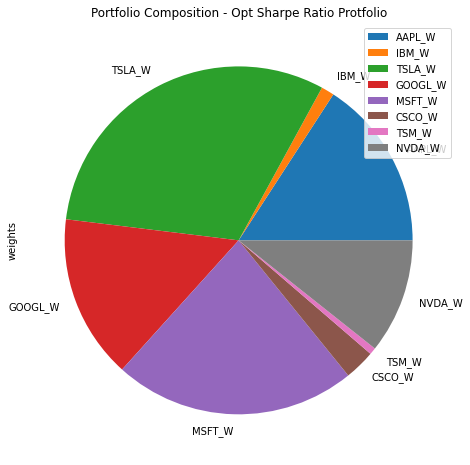

In [33]:
portfolio_opt_sharpe_ratio_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_opt_sharpe_ratio)

# Plot the pie charts of the porfolio allocation/weights
portfolio_opt_sharpe_ratio_weights.plot.pie(y='weights', title='Portfolio Composition - Opt Sharpe Ratio Protfolio', figsize=(10,8))

### Compute Actual Realized Portfolio Value under the Test dataframe components

In [34]:
asset_prices_test_beg_df = pd.DataFrame(sql_basket_indexed_df.iloc[num_historical_days_percent, :]).drop('SP500_index', axis=0, inplace=False)
asset_prices_test_end_df = pd.DataFrame(sql_basket_indexed_df.iloc[num_days_total-1, :]).drop('SP500_index', axis=0, inplace=False)

print("Beginning and end dates used for the testing the performance of the portfolio")
display(asset_prices_test_beg_df.T)
display(asset_prices_test_end_df.T)

Beginning and end dates used for the testing the performance of the portfolio


AAPL         IBM   TSLA       GOOGL       MSFT       CSCO  \
2021-10-21  149.479996  122.686424  298.0  141.886002  310.76001  55.689999   

                   TSM        NVDA  
2021-10-21  116.290001  226.919998

AAPL         IBM      TSLA       GOOGL        MSFT    CSCO  \
2022-10-20  145.479996  127.830002  213.3396  101.739998  239.789993  42.355   

                  TSM        NVDA  
2022-10-20  65.050003  126.360001

### Monte-Carlo Dataframe Weights List

In [35]:
# Arrange Monte Carlo dataframe weights list
portfolio_mc_min_weights = mpt.mpt_pe_get_mc_weights(portfolio_min_weights)
portfolio_mc_max_weights = mpt.mpt_pe_get_mc_weights(portfolio_max_weights)
portfolio_mc_opt_sharpe_ratio_weights = mpt.mpt_pe_get_mc_weights(portfolio_opt_sharpe_ratio_weights)

In [36]:
investment_pnl_min = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_min_weights))[0][0]
investment_pnl_max = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_max_weights))[0][0]
investment_pnl_opt_sharpe_ratio = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_opt_sharpe_ratio_weights))[0][0]

print("Actual realized portfolio value for min/max/opt_sharpe allocations:")
display(investment_pnl_min)
display(investment_pnl_max)
display(investment_pnl_opt_sharpe_ratio)

Actual realized portfolio value for min/max/opt_sharpe allocations:


8226.905010223389

7437.688594818115

7567.800884246826

### Run Monte-Carlo Simulations
---
* Compute expected Returns, and 
* Compare against realized returns

In [37]:
print("Number of MC runs:", mpt.num_mc_runs)

Number of MC runs: 500


In [38]:
# Slice the "test" dataframe to use for MC sims to predict returns
asset_mc_test_df = asset_mkt_prices_test_df.drop('SP500_index', axis=1, inplace=False)

In [39]:
# Arrange Monte-Carlo dataframe to have tuples for column names
asset_prices_mc_col_df = mpt.mpt_pe_get_mc_porfolio_df(asset_mc_test_df)

In [40]:
# Configure the Monte-Carlo simulation to forecast 1 year (20% of 5 years period)
# cumulative returns on the minimum risk portfolio weights
# Run 500 samples.
MC_min_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_min_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = num_test_days_percent
)

# Review the simulation input data
print("Monte Carlo Portfolio (Min)")
MC_min_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Min)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   
2022-10-18  143.750000     0.009409  122.940002     0.011685  220.190002   
2022-10-19  143.860001     0.000765  122.510002    -0.003498  222.039993   

                              GOOGL                     MSFT               \
           daily_return       close daily_return       close daily_return   
Date                                                                        
2022-10-13     0.020622   99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456   96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052   99.970001     0.035315  237.529999     0.039246   
2022-10-18     0.003829  100.769997     0.008002  238.500000     0.004084   
2022-10-19     0.008402   99.629997    -0.011313  236.479996    -0.008470   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   
2022-10-18  41.790001     0.011864  63.709999    -0.018185  119.669998   
2022-10-19  41.880001     0.002154  63.660000    -0.000785  120.510002   

                         
           daily_return  
Date                     
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876  
2022-10-18     0.006645  
2022-10-19     0.007019

In [41]:
# Run the Monte Carlo simulation to forecast 1 year cumulative returns (min)
MC_min_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    0.999846  1.005518  0.997054  1.018847  1.009024  0.995251  1.002446   
2    0.998608  1.017181  0.999340  1.025431  1.011464  1.007181  0.989432   
3    0.989540  1.016978  1.019104  1.012386  1.013783  0.998050  0.994923   
4    1.002543  1.020444  1.014170  1.023552  1.003772  0.988227  0.994131   
..        ...       ...       ...       ...       ...       ...       ...   
248  0.961936  0.805102  0.939609  0.824841  0.882754  0.738688  0.747988   
249  0.977893  0.806560  0.940203  0.834085  0.876599  0.731054  0.737988   
250  0.974573  0.802234  0.941780  0.825237  0.877800  0.727320  0.734219   
251  0.973153  0.794688  0.938900  0.833270  0.884341  0.727506  0.731223   
252  0.976973  0.798649  0.958635  0.835127  0.885602  0.715784  0.723741   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    0.983179  0.987674  0.999195  ...  0.989772  0.992926  0.992323   
2    0.991201  0.987004  0.995823  ...  0.980398  0.990426  0.994745   
3    0.993717  0.998752  0.995396  ...  0.988955  0.988209  0.991318   
4    0.998664  0.999106  0.980699  ...  0.987970  0.991321  0.990436   
..        ...       ...       ...  ...       ...       ...       ...   
248  0.859844  0.700104  1.048861  ...  0.721192  0.795293  0.835198   
249  0.855990  0.696617  1.047063  ...  0.712611  0.807328  0.838516   
250  0.851371  0.698276  1.049867  ...  0.715808  0.821861  0.833873   
251  0.849163  0.704595  1.046644  ...  0.720831  0.824674  0.839137   
252  0.850621  0.701564  1.048296  ...  0.713914  0.818681  0.831381   

          493       494       495       496       497       498       499  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    1.001567  0.992733  0.997135  0.993485  1.008307  0.995802  0.994266  
2    0.990649  1.000722  0.996732  0.982855  1.011733  1.006972  0.993075  
3    0.979237  0.995231  1.006235  0.978941  1.014688  1.016851  0.997053  
4    0.990970  0.990826  1.009976  0.973319  1.021688  1.022824  1.009978  
..        ...       ...       ...       ...       ...       ...       ...  
248  0.641179  0.796579  0.781335  0.665582  0.904823  0.652250  0.904312  
249  0.642095  0.795981  0.773910  0.674177  0.912838  0.645576  0.899823  
250  0.637502  0.784032  0.769344  0.676051  0.908408  0.647231  0.896712  
251  0.637706  0.775075  0.769142  0.684208  0.902924  0.645057  0.887522  
252  0.646550  0.775168  0.769816  0.689834  0.907474  0.637446  0.879997  

[253 rows x 500 columns]

In [42]:
# Configure the Monte-Carlo simulation to forecast 1 year (20% of 5 years period)
# cumulative returns on the maximum return risk-tolerant portfolio weights
# Run 500 samples.
MC_max_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_max_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = num_test_days_percent
)

# Review the simulation input data
print("Monte Carlo Portfolio (Max)")
MC_max_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Max)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   
2022-10-18  143.750000     0.009409  122.940002     0.011685  220.190002   
2022-10-19  143.860001     0.000765  122.510002    -0.003498  222.039993   

                              GOOGL                     MSFT               \
           daily_return       close daily_return       close daily_return   
Date                                                                        
2022-10-13     0.020622   99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456   96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052   99.970001     0.035315  237.529999     0.039246   
2022-10-18     0.003829  100.769997     0.008002  238.500000     0.004084   
2022-10-19     0.008402   99.629997    -0.011313  236.479996    -0.008470   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   
2022-10-18  41.790001     0.011864  63.709999    -0.018185  119.669998   
2022-10-19  41.880001     0.002154  63.660000    -0.000785  120.510002   

                         
           daily_return  
Date                     
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876  
2022-10-18     0.006645  
2022-10-19     0.007019

In [43]:
# Run the Monte Carlo simulation to forecast 1 year cumulative returns (max)
MC_max_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    0.988665  0.996691  1.025481  0.965356  1.021305  0.994120  1.004232   
2    0.986817  1.010191  1.042429  0.990060  0.987034  0.988160  0.973623   
3    0.999954  0.987484  1.031053  1.009982  1.007728  0.985096  0.971065   
4    1.013249  0.977518  1.040241  1.035423  0.992327  0.970494  0.982765   
..        ...       ...       ...       ...       ...       ...       ...   
248  0.854887  0.962422  0.494397  0.700752  1.036557  0.586643  0.810003   
249  0.883664  0.945955  0.481766  0.676712  1.066435  0.582868  0.826739   
250  0.867710  0.925549  0.492688  0.693116  1.083699  0.562481  0.782014   
251  0.874251  0.914585  0.504928  0.695855  1.047461  0.543023  0.800920   
252  0.869276  0.936917  0.505896  0.684028  1.080806  0.534337  0.792052   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.019440  1.002690  0.978524  ...  0.974956  1.011308  1.029284   
2    1.009617  0.997283  0.930430  ...  0.967925  1.006925  1.042336   
3    1.010221  0.997434  0.924659  ...  0.969258  1.002965  1.040279   
4    1.018882  1.011193  0.947816  ...  0.922140  0.975070  1.061623   
..        ...       ...       ...  ...       ...       ...       ...   
248  1.134748  0.623777  0.922635  ...  1.279328  0.512088  0.683601   
249  1.151416  0.619605  0.923497  ...  1.260727  0.507936  0.667147   
250  1.152770  0.619825  0.906249  ...  1.258890  0.511418  0.676927   
251  1.146846  0.598911  0.886680  ...  1.246862  0.524041  0.680980   
252  1.128735  0.578203  0.933561  ...  1.211671  0.534100  0.683879   

          493       494       495       496       497       498       499  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    1.009603  0.957413  0.993454  1.021870  0.987567  1.007464  1.022449  
2    1.029915  0.963782  1.021013  1.010468  0.998201  1.044066  0.995957  
3    1.006184  0.969433  0.993269  0.999701  0.997373  1.062201  0.982370  
4    0.989788  1.023622  0.992115  1.047923  0.983559  1.053134  0.988049  
..        ...       ...       ...       ...       ...       ...       ...  
248  0.507912  1.037935  1.760110  0.637569  1.132538  0.822544  0.848095  
249  0.502433  1.085419  1.711320  0.638349  1.151023  0.820315  0.829414  
250  0.491720  1.096574  1.790258  0.645652  1.167892  0.818090  0.835516  
251  0.504271  1.080232  1.731483  0.640214  1.168913  0.812666  0.881568  
252  0.524115  1.083890  1.700683  0.644753  1.139784  0.831073  0.908385  

[253 rows x 500 columns]

In [44]:
# Configure the Monte-Carlo simulation to forecast 1 year (20% of 5 years period)
# cumulative returns on the optimal risk-return Sharpe Ratio of the portfolio
# Run 500 samples.

MC_opt_sharpe_ratio_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_opt_sharpe_ratio_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = num_test_days_percent
)

# Review the simulation input data
print("Monte Carlo Portfolio (Opt Sharpe)")
MC_opt_sharpe_ratio_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Opt Sharpe)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   
2022-10-18  143.750000     0.009409  122.940002     0.011685  220.190002   
2022-10-19  143.860001     0.000765  122.510002    -0.003498  222.039993   

                              GOOGL                     MSFT               \
           daily_return       close daily_return       close daily_return   
Date                                                                        
2022-10-13     0.020622   99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456   96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052   99.970001     0.035315  237.529999     0.039246   
2022-10-18     0.003829  100.769997     0.008002  238.500000     0.004084   
2022-10-19     0.008402   99.629997    -0.011313  236.479996    -0.008470   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   
2022-10-18  41.790001     0.011864  63.709999    -0.018185  119.669998   
2022-10-19  41.880001     0.002154  63.660000    -0.000785  120.510002   

                         
           daily_return  
Date                     
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876  
2022-10-18     0.006645  
2022-10-19     0.007019

In [45]:
# Run the Monte Carlo simulation to forecast 1 year cumulative returns of the optimal (balanced) Sharpe Ratio
MC_opt_sharpe_ratio_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    0.986650  1.010435  1.021044  0.991545  1.007667  1.014527  1.008764   
2    0.992640  1.032270  1.016602  0.965552  0.998757  1.010830  0.998254   
3    0.997738  1.047309  1.033992  0.956707  1.001532  1.017654  0.997447   
4    1.001776  1.055944  1.047802  0.934109  0.999562  1.006994  0.983492   
..        ...       ...       ...       ...       ...       ...       ...   
248  0.834104  0.989148  0.844461  0.754123  1.412140  0.951480  0.651600   
249  0.835036  0.985894  0.816151  0.756877  1.420431  0.939870  0.662252   
250  0.842973  0.982029  0.814297  0.765648  1.437804  0.942792  0.667337   
251  0.843574  0.976403  0.821731  0.789007  1.439058  0.937434  0.674122   
252  0.819870  0.972216  0.818169  0.784533  1.427581  0.950211  0.689446   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.013996  0.996115  1.005966  ...  1.013890  0.991952  0.988523   
2    1.014709  0.975025  1.007111  ...  1.035033  0.971940  0.983559   
3    1.023721  0.950904  0.981696  ...  1.057156  0.967237  0.995507   
4    1.023229  0.929145  0.991141  ...  1.058999  0.912997  0.994707   
..        ...       ...       ...  ...       ...       ...       ...   
248  0.818721  0.892365  0.698864  ...  0.606278  0.809513  0.766181   
249  0.816739  0.883773  0.706003  ...  0.607288  0.793044  0.771569   
250  0.814768  0.874770  0.730523  ...  0.600085  0.793497  0.763419   
251  0.809349  0.882456  0.716998  ...  0.600926  0.787225  0.768522   
252  0.802874  0.889782  0.689986  ...  0.608634  0.784135  0.763558   

          493       494       495       496       497       498       499  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    0.979717  1.014589  0.983451  0.993559  0.994843  0.993226  1.011535  
2    0.977529  1.035950  0.967442  0.996956  1.017119  0.998344  0.989828  
3    0.974772  1.041451  0.956271  0.982272  0.990899  1.009331  1.010137  
4    0.958525  1.060522  0.957343  0.981194  0.995422  1.013485  1.020141  
..        ...       ...       ...       ...       ...       ...       ...  
248  0.732927  1.204198  1.055532  0.977598  0.936456  0.705458  0.551885  
249  0.737972  1.183005  1.045738  0.994413  0.945928  0.717465  0.545107  
250  0.760654  1.167975  1.031572  1.009641  0.947995  0.703167  0.546984  
251  0.760661  1.168006  0.991755  1.031349  0.955150  0.702342  0.538049  
252  0.760297  1.140367  0.981257  1.038819  0.915710  0.703515  0.538022  

[253 rows x 500 columns]

### 4. Visualizations

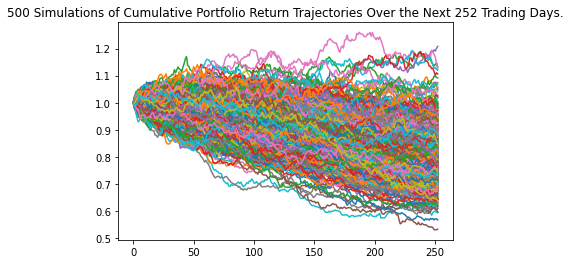

In [46]:
# Visualize the 1 year Monte Carlo simulation by creating an overlay line plot

line_plot_min_portfolio_plot = MC_min_portfolio.plot_simulation()

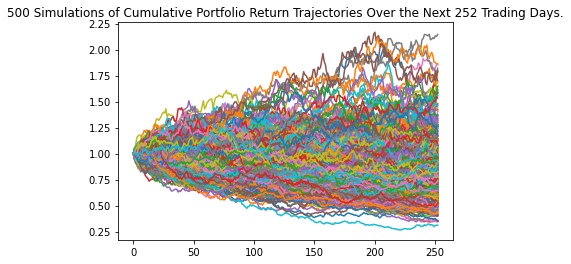

In [47]:
# Visualize the 1 year Monte Carlo simulation by creating an
# overlay line plot
line_plot_max_portfolio_plot = MC_max_portfolio.plot_simulation()

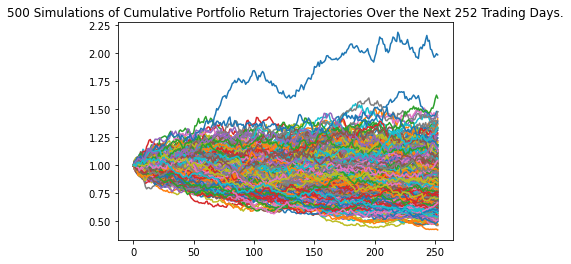

In [48]:
# Visualize the 1 year Monte Carlo simulation by creating an
# overlay line plot
line_plot_opt_sharpe_ratio_portfolio_plot = MC_opt_sharpe_ratio_portfolio.plot_simulation()

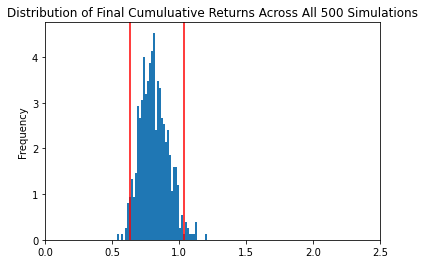

In [49]:
# Visualize the probability distribution of the 1 year Monte Carlo simulation 
# by plotting a histogram
plt.xlim([0, 2.5])
distribution_plot_min_portfolio_plot = MC_min_portfolio.plot_distribution()

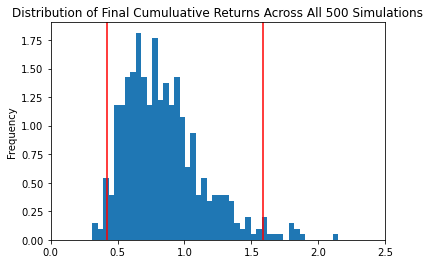

In [50]:
# Visualize the probability distribution of the 1 year Monte-Carlo simulation 
# by plotting a histogram
plt.xlim([0, 2.5])
distribution_plot_max_portfolio_plot = MC_max_portfolio.plot_distribution()

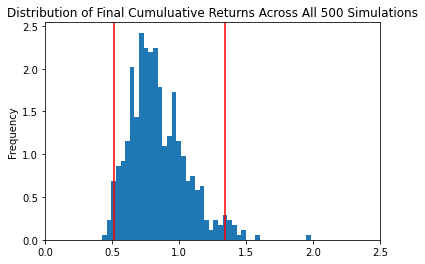

In [51]:
# Visualize the probability distribution of the 1 year Monte Carlo simulation 
# by plotting a histogram
plt.xlim([0, 2.5])
distribution_plot_opt_sharpe_ratio_portfolio_plot = MC_opt_sharpe_ratio_portfolio.plot_distribution()

In [52]:
# Generate summary statistics from the 1 year Monte-Carlo simulation results
# Save the results as a variable
table_min_portfolio_weight = MC_min_portfolio.summarize_cumulative_return()

# Review the 1 year Monte Carlo summary statistics
print(table_min_portfolio_weight)

count           500.000000
mean              0.811805
std               0.104940
min               0.533259
25%               0.737645
50%               0.802956
75%               0.878402
max               1.207837
95% CI Lower      0.630008
95% CI Upper      1.034812
Name: 252, dtype: float64


In [53]:
# Generate summary statistics from the 1 year Monte-Carlo simulation results
# Save the results as a variable
table_max_portfolio_weight = MC_max_portfolio.summarize_cumulative_return()

# Review the 1 year Monte Carlo summary statistics
print(table_max_portfolio_weight)

count           500.000000
mean              0.841928
std               0.292481
min               0.310513
25%               0.629658
50%               0.793890
75%               0.985029
max               2.146118
95% CI Lower      0.421036
95% CI Upper      1.584422
Name: 252, dtype: float64


In [54]:
# Generate summary statistics from the 1 year Monte Carlo simulation results
# Save the results as a variable
table_opt_sharpe_ratio_portfolio_weight = MC_opt_sharpe_ratio_portfolio.summarize_cumulative_return()

# Review the 1 year Monte Carlo summary statistics
print(table_opt_sharpe_ratio_portfolio_weight)

count           500.000000
mean              0.842045
std               0.212023
min               0.423091
25%               0.696314
50%               0.807507
75%               0.966420
max               1.984634
95% CI Lower      0.514268
95% CI Upper      1.339170
Name: 252, dtype: float64


In [55]:
# Print the initial investment in the portfolio
print(f"The initial investment of the portfolio is ${mpt.initial_test_investment:0.2f}")

The initial investment of the portfolio is $10000.00


In [56]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the MIN portfolio

# Get the lower and upper CI values
ci_lower_95per = table_min_portfolio_weight[8]
ci_upper_95per = table_min_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2) 
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2)

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current minimum portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio was ${investment_pnl_min:0.2f}")


There is a 95% chance that the current minimum portfolio value of $10000.00, will end within the range of $6300.08 and $10348.12.
The actual realized value of the portfolio was $8226.91


In [57]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the MAX portfolio

# Get the lower and upper CI values
ci_lower_95per = table_max_portfolio_weight[8]
ci_upper_95per = table_max_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2)
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2) 

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current maximum portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio was ${investment_pnl_max:0.2f}")


There is a 95% chance that the current maximum portfolio value of $10000.00, will end within the range of $4210.36 and $15844.22.
The actual realized value of the portfolio was $7437.69


In [58]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the OPT SHARPE RATIO portfolio

# Get the lower and upper CI values
ci_lower_95per = table_opt_sharpe_ratio_portfolio_weight[8]
ci_upper_95per = table_opt_sharpe_ratio_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltive returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2) 
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2) 

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current optimal Sharpe Ratio of a given portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio was ${investment_pnl_opt_sharpe_ratio:0.2f}")


There is a 95% chance that the current optimal Sharpe Ratio of a given portfolio value of $10000.00, will end within the range of $5142.68 and $13391.70.
The actual realized value of the portfolio was $7567.80
